In [15]:
import json
import matplotlib.pyplot as plt
from vowpalwabbit import pyvw
from vowpalwabbit import LabelType

In [16]:
def parse_vw_format(line):
    cost_part, rest = line.split(":", 1)
    minmax_part, action_and_features = rest.split("]:", 1)
    min_val, max_val = map(float, minmax_part.strip("[").split(","))
    action, features_str = action_and_features.strip().split(" |", 1)
    
    context = {}
    for feat in features_str.split():
        if ":" in feat:
            k, v = feat.split(":")
            context[k] = float(v)
        else:
            context[feat] = 1
    
    label = {
        "action": float(action),
        "cost": float(cost_part),
        "pdf_value": 1.0 / (max_val - min_val) if max_val > min_val else 1.0
    }

    return {"context": context, "label": label}


In [17]:
def load_examples(path):
    examples = []
    with open(path, "r") as f:
        for line in f:
            if line.strip():
                try:
                    ex = parse_vw_format(line.strip())
                    examples.append(ex)
                except Exception as e:
                    print(f"Skipping invalid line: {line}\nError: {e}")
    return examples

In [26]:
def run_scheduler_simulation_from_file(vw, examples):
    reward_rate = []
    total_cost = 0.0
    hits = 0

    for i, ex_data in enumerate(examples, start=1):
        context = ex_data["context"]
        label = ex_data["label"]

        # Predict
        pred_ex = vw.example(json.dumps({"c": context}), labelType=LabelType.CONTINUOUS)
        pred_ex.finish()
        predicted_action = vw.predict(pred_ex)


        # Calculate reward and track
        cost = label["cost"]
        total_cost += cost
        if cost <= -0.75:
            hits += 1

        reward_rate.append(-1 * total_cost / i)

        # Learn
        learn_ex = vw.parse(json.dumps({
            "_label_ca": {
                "action": predicted_action,
                "cost": cost,
                "pdf_value": label["pdf_value"]
            },
            "c": context
        }), LabelType="continuous")

        vw.learn(learn_ex)
        vw.finish_example(learn_ex)


    return reward_rate, hits

In [19]:
def plot_reward_rate(num_iterations, reward_rate, title):
    plt.figure(figsize=(10, 4))
    plt.plot(range(1, num_iterations + 1), reward_rate)
    plt.xlabel("Iteration")
    plt.ylabel("Avg Reward (–Cost)")
    plt.title(title)
    plt.ylim([0, 1])
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Skipping invalid line: ca 0:[9.0,19.0]:14.0 | event_type:study duration:0.5 due_in_hrs:5 daily_free_time:

Error: could not convert string to float: 'study'
Skipping invalid line: ca 1:[9.0,19.0]:15.0 | event_type:study duration:0.75 hours_until_due:24 daily_free_time:6.0

Error: could not convert string to float: 'study'
Skipping invalid line: ca 0:[9.0,19.0]:16.3 | event_type=study duration:0.25 hours_until_due:72.0 daily_free_time:8.0

Error: could not convert string to float: 'ca 0'
Skipping invalid line: ca 1:[9.0,20.0]:13.0 |event_type study task_duration:1.5 hours_until_due:6 daily_free_time:4.5

Error: could not convert string to float: 'ca 1'
Skipping invalid line: ca 0:[9.0,20.0]:10.5 |event_type study task_duration:1.0 hours_until_due:4 daily_free_time:4.5

Error: could not convert string to float: 'ca 0'
Skipping invalid line: ca 1:[9.0,20.0]:15.0 |event_type study task_duration:0.75 hours_until_due:24 daily_free_time:4.5

Error: could not convert string to float: 'ca 1'
Sk

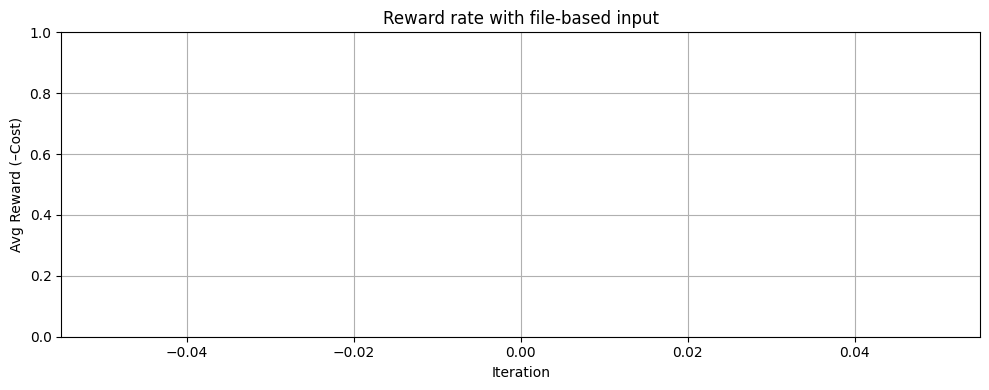

In [27]:
if __name__ == "__main__":
    train_file = "anya_train.vw"
    examples = load_examples(train_file)

    num_actions = 32
    bandwidth = 1
    min_value = 9
    max_value = 20

    vw = pyvw.Workspace(
        f"--cats {num_actions} --bandwidth {bandwidth} "
        f"--min_value {min_value} --max_value {max_value} "
        "--json --quiet"
    )

    ctr, hits = run_scheduler_simulation_from_file(vw, examples)
    vw.finish()

    plot_reward_rate(len(ctr), ctr, "Reward rate with file-based input")